<a href="https://colab.research.google.com/github/GvdDool/Notebook-test/blob/master/SimplifyFileSharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simplify File Sharing
##Coding Example for working with Google Drive's Shared Folders in Collaboration Projects

Recently, a data-sharing problem came up again, and I thought this would be a good time to design a method to work with shared folders. I am an independent GIScience professional, and I often have to work with different organisations simultaneously, and no organisation works with the data the same way because they all have their own culture and work ethics. Luckily, there are some practices they have in common, and one of them is working with a cloud-based data management system, often Google, but this could also be One-Drive (from Microsoft) of Dropbox.

In this post, I will try to explain how I work, using Python, with Shared Folders in the Google Ecosystem.

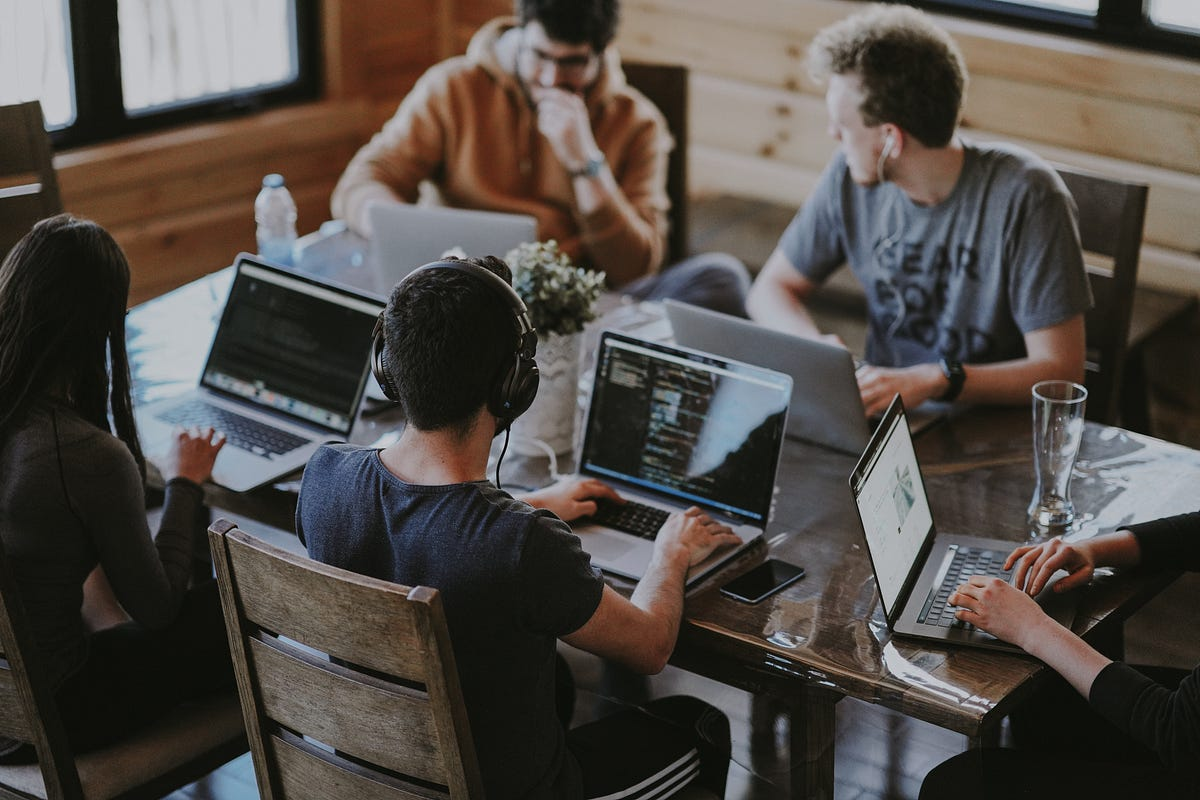

##Use Case
File management is very individual when working on a local machine, and (hopefully) standardised, or at least has some standardisation, when working in an organisation. Working with shared folders is an option when you don't have direct access to a production folder, but the organisation can share a specifically designated working folder with you to exchange files. In this example, an organisation has granted access to a folder called DATA on their Google Drive repository, and it's agreed that we can use this folder to exchange files.

##Local file management
To explain quickly, for people unfamiliar with Google Drive file sharing, the process starts with receiving an email inviting you to contribute to a specific folder; see the invitation (left) below. In the invitation is a button which will open a web browser with the Google Drive interface (right) associated with the Google email of the receiver of the invitation.

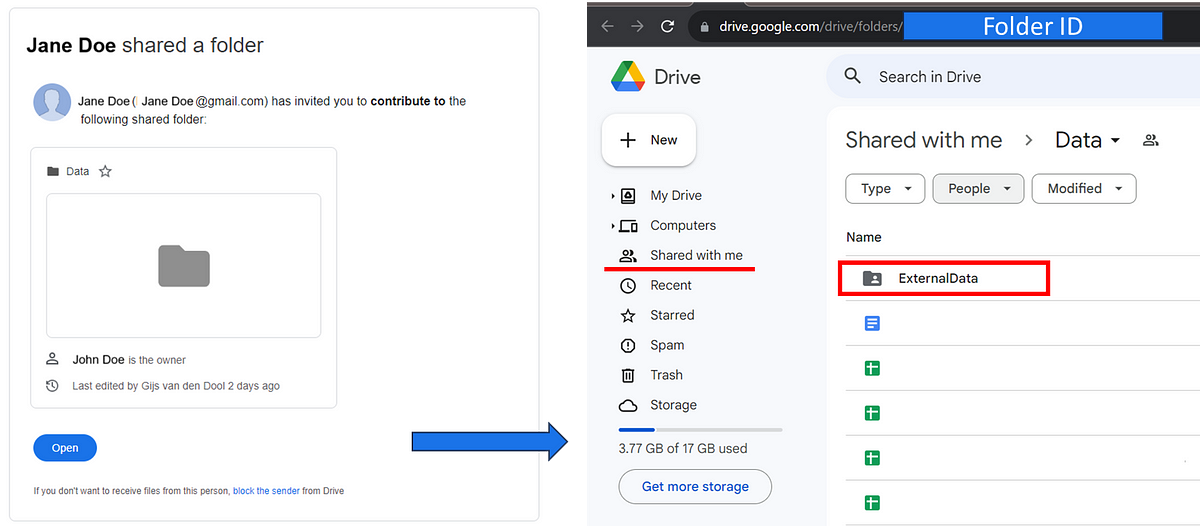

There are a few important pieces of information hidden in the interface, and understanding them early will help with the rest of the process.
- In the URL (top of the screen), there is a masked ID, this is the ID Google is using to track all the operations on this folder, and this is the ID we will fetch in the Python code later in this post.
- Then it says: "Shared with me" and the name of the shared folder; also, this is important because when we mount the Google Drive to the CoLab notebook, we will see that this category is not available.
- And finally, we see the files and folders under Data; this means we can access the information we need, and add new files to the folder. Still, there could be a problem with the folder's security settings, so a good test at this stage is to create a small text file, and drag-and-drop in the folder "ExternalData", to verify that you have full access.

To make the "Shared with me" folder accessible, we need to link this folder to the local/personal drive. We can do this by creating a Shortcut, but this is a manual step, and will be different for everyone. To access a shared with you folder or file in Google Colab, you have to:
1. Go to Shared with me in Google Drive.
2. Select the folder or file you want to access.
3. Right-click on it and choose "Add shortcut to drive", and a pop-up window will appear, "Select MyDrive", then click on "Add Shortcut".
4. Place the shortcut in a location on your drive that you can find back easily; in the setup I use, the location for Shortcuts is "__Shared", ensuring that the folder with the shortcuts is at the top of the folder list under "MyDrive", and then a subdirectory for the organisation.
5. Rename the shortcut to a meaningful name; I use "DataDevelopement" in this example. The file location and name conventions are very personal, and it doesn't matter for the program where the files are stored or how they are called, but having some structure can save some headaches later.

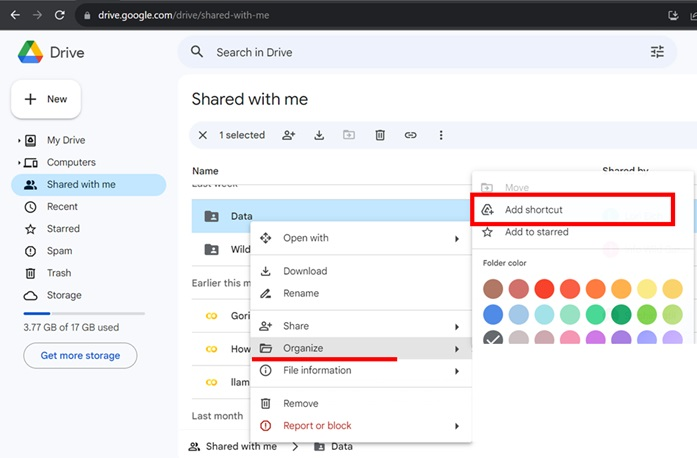

With the local file system organised, and the personal Google Drive configured, we can try to work with this shared folder in a Python notebook and automate the file sharing in the project.

<br>


---


#Installation
This project is based on a Google Colab, or "Collaboratory", notebook, and the advantage of using this environment is that it allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

These are very important points when working with organisations which have their internal structures, but as an external collaborator, you are not often getting direct access to the code base (and this can have many different reasons, from security concerns to project management constraints); I will share a gist to the notebook at the end of this post.
Importing modules and packages
For this example, only the necessary packages are loaded to the notebook's runtime, and we need a few specific libraries to work with the shared drive.

##Google autotorisation



In [2]:
from oauth2client.client import GoogleCredentials

from google.colab import auth as google_auth
google_auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Using oauth2client and the Google Credentials will make working with the files easier. There are alternatives, like downloading a JSON file with the credentials, and there will be situations where working with the JSON file will be preferred over using Google Credentials, but as this is a project with no sensitive data using the oauth2client library is giving enough protection.

##pydrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

pydrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks, and one of these functionalities is handling get responses when querying the Google Drive File system. Google Drive stores all objects by ID, and the IDs are linked by relational information in the objects. It is possible to access this information by the API (see the next code block), but the wrapper is doing all the heavy lifting for us when we create a GoogleDriveFileList instance with the parameters of Files.list() as dict. Calling GetList() will get all files that match your query as a list of GoogleDriveFile.

##Google API Client

In [4]:
# Google API client:
from googleapiclient.discovery import build

# Initialize the Google Drive API client
drive_service = build('drive', 'v3')

The Google API Client is a large library, and it has many functionalities, but for this project, we only need one module: build. The build module constructs a Resource Object for interacting with an API and returns the methods for interacting with the service. The pydrive library will handle the basic functions very well, like creating, updating, and deleting files, but there are a few moments (in this project) when we need more advanced functionality, and having access to the "service" allows us to extract information not captured by the pydrive methods.



> This concludes the configuration of the notebook. In this example, we don't need more libaries than the loaded libaries for file management, and with the libraries loaded, we can have a look at what they are doing.

<br>

---

##File Management in the Notebook
Up to this point, a few things have happened:
Google authorisation is set up,
We created access to the drive (for read/write access), and
The Pydrive package is available to navigate on the drive

Hopefully, when you are following along and running the code, you will see the image on the right, after having refreshed the panel. You can see the Shortcut in the image as a folder under "__Shared", and we don't see the "Shared with me" section, but because we have the Shortcut, we don't need to see the "Shared with me" files.



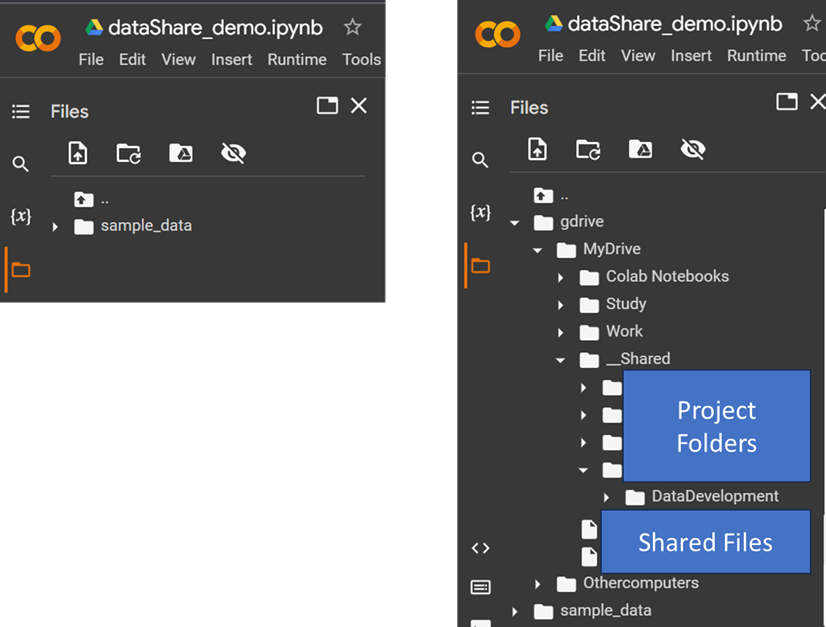

Google Drive works differently than the file management in the local Operating Systems, the physical location of the files is not important because the objects are managed by ID in an unstructured DataLake, and we can access the files and folders by the ID.
Unfortunately, while os.path (in Python) has walk functions to go over the file system, a similar method doesn't exist for Google Drive (or I am not aware of this method). However, we can use the pydrive library, and walk manually through the folders in the directory tree, and luckily, we know where we want to go from the path of the folder. So, we don't need to walk through the whole structure, but we can use the folder names of the data path to go deeper into the folder tree.
So, we loop over the small list (in this example, three items) to find the ID and use this ID to go to the next level. Note that the fourth level is commented out; we will get to this level in the second part of the file handling section of this notebook.

The loop, in the code block below, starts in the root, and when it finds an item in the list, the loop will use the ID of the object to go to the next level on the list, and if an item is not found, the code will prompt that the folder is not found and will not look for any folder deeper in the structure. The loop concludes with either the ID of the Shortcut folder or prompts that the folder is not found.

In [6]:
# File handling testing:
# There are in this example three folder levels:
# /content/gdrive/MyDrive/__Shared/<your Project>/DataDevelopment

your_Project = "YourFolderName"

# Update these to your structure:
folderList1 = ["__Shared", your_Project ,"DataDevelopment"] #, "ExternalData"]

# Trying to copy the created dummy file:
boo_foundFolder = False
fileID = "root"
level = 0

# View all folders and file in your Google Drive
# First loop over the list:
print("File and Folder structure - check with IDs")
for folderName in folderList1:
  print(f"Checking: {folderName}")

  if boo_foundFolder or fileID == "root": #first run
    boo_foundFolder = False

    fileList = drive.ListFile({'q': f"'{fileID}' in parents and trashed=false"}).GetList()
    for file in fileList:
      # Testing the name:
      if(file['title'] == folderName):
        fileID = file['id']
        boo_foundFolder = True

        level += 1
      # end if
    # end for

    if boo_foundFolder == False:
      print(f"folder not found")
      break
    # end if
  # end if
# end for

print(f"Did we find the folder: {boo_foundFolder}")
if boo_foundFolder:
  print(fileID)
  ShortCutID = fileID
else:
  ShortCutID = 0

File and Folder structure - check with IDs
Checking: __Shared
Checking: YourFolderName
folder not found
Did we find the folder: False


At this moment, we have the local file ID for the working folder, but before we can look for files in this location we need to match this local ID with the target ID of the shared folder. To find this information, we have to look deeper into the Google infrastructure, and to do this, we need a helper: the drive_service. We activated the helper while we were loading the project, and we didn't get a warning, which means we have access to the service by using the API, and requesting information by ID.
The details we need are best collected through a simple function, like the findTargetID function in the next code block. In this function, the <fileID> is the Shortcut ID we found by looping over the names in the folders, and by calling 'drive_service.files().get' and specifying the fields, we get the target ID of the folder (this will be the same ID as in the URL of the web interface of Google Drive (see Figure 1).

In [7]:
def findTargetID(fileID, drive_service):
  # The ID of the shared file you want to get ShortcutDetails from
  file_id = fileID

  try:
      # Get the file details
      file = drive_service.files().get(fileId=file_id,
                                      fields="id, shortcutDetails").execute()

      # Check if the file is a shortcut
      if 'shortcutDetails' in file:
          shortcut_details = file['shortcutDetails']
          print("Shortcut Details:")
          print(f"Target ID: {shortcut_details['targetId']}")
          print(f"Target MIME Type: {shortcut_details['targetMimeType']}")
      else:
          print("The file is not a shortcut.")
      # end if

  except Exception as e:
      print(f"An error occurred: {e}")

  return shortcut_details['targetId']

if boo_foundFolder:
  targetID = findTargetID(fileID, drive_service)
  print(targetID)
else:
  print("Folder not found")

With this target ID, we have access to the actual shared folder on the Google Data Server, and we are not working on the shortcut folder anymore.


> To recap, the reason we created the shortcut folder was to be able to see the folder in our mounted list of folders. The category "Shared with me" is not mounted, but the shortcuts are. So with this new ID we can look for files.


---
<br>

##Looking for files
We have now what we need, the Target ID of the folder shared with us at the beginning of the process, and with that ID, all normal file operations are available to us.

We can verify that we have enough permissions on the shared folder by first creating a small text file in the Run Time environment; creating this file also confirms that we have access to the Run Time environment because it will appear in the left panel of the web interface of the CoLab notebook when the file is correctly created.



In [ ]:
# Create a test file:
with open('example.txt', 'w') as f:
  f.write('This is an example file, to test CoLab file sharing')
# this file is now sitting in the runtime space of the notebook
# (see left plane, under files)

Now the idea is to move this file to the "Shared with me" folder "Data", which we renamed "DataDevelopment" in the Shortcut, but the function in the previous section provided the <target ID>, and we can use now this ID to check if the file we just created in the Run Time Environment is available on the shared drive.


In [ ]:
if boo_foundFolder:
  print("folder found")
  folderID = targetID

  file_on_drive = False
  file_id = 0

  # check if the file is on the drive:
  fileList = drive.ListFile({'q': f"'{folderID}' in parents and trashed=false"}).GetList()
  for file in fileList:
    if(file['title'] == "example.txt"):
      file_on_drive = True
      fileID = file['id']
    # end if
  # end for

  if file_on_drive:
  #Overwrites the existing Google drive file."""
    file1 = drive.CreateFile({'id': fileID})
    strFileHandling = "Updated"

  else:
    file1 = drive.CreateFile({"mimeType": "text/csv",
                             "parents": [{"kind": "drive#fileLink",
                                        "id": folderID}]})
    strFileHandling = "Created"
  # end if

  # creating the binding to the file in the Run-Time environment:
  file1.SetContentFile("example.txt")

  # copying the file to the Google Drive:
  file1.Upload()

  print(f'{strFileHandling} file %s with mimeType %s' % (file1['title'], file1['mimeType']))

else:
  print("folder not found")
# end if

Running the code above will either create a new file in the shared folder or update (overwrite) the file when the file is found.
Creating a workspace

There is a second reason to use the Shortcut ID to find the Target ID and that is to find items under the shared folder. As mentioned before, Google Drive manages everything by ID, and the Shortcut ID doesn't have any children, so using this ID to find new items will result in an empty list. This can be tested by including the "ExternalData" folder name in the first list of folders; the first list will not find this folder. However, restarting the loop with the Target ID will find this folder.

In the code snippet below, a new folder list is created, using the folder names below the "Shared with me" folder name. The "ExternalData" folder is available (see Figure 1), but "NewDataFolder" is not yet created.

In [ ]:
# Update these to your structure:
# ... DataDevelopment/ExternalData/__CoLab_Notebook

# Setting the Working Folder:
folderList2 = ["ExternalData", "NewDataFolder"]

We can use the same loop structure as before, but now instead of starting in the ROOT, we are starting with the Target ID, and the loop will find the "ExternalData" folder, but not the new data folder.
As the working folder doesn't exist yet we can use <drive_service.files> to create this new folder, and with the same method all files that need to be transferred from the Run Time Environment to the "Shared with me" folder.

In [ ]:
print("File and Folder structure - check with TARGET IDs")
boo_foundFolder = False
fileID = targetID

for folderName in folderList2:
  print(f"Checking: {folderName}")

  if boo_foundFolder or fileID == targetID: #first run
    boo_foundFolder = False

    fileList = drive.ListFile({'q': f"'{fileID}' in parents and trashed=false"}).GetList()

    for file in fileList:
      # Testing the name:
      if(file['title'] == folderName):
        #print('Title: %s, ID: %s' % (file['title'], file['id']))
        fileID = file['id']
        print(f"{level}: {fileID}")

        boo_foundFolder = True

        level += 1
      # end if
    # end for

    if boo_foundFolder == False:
      print(f"folder not found")
      break
    # end if
  # end if
# end for

print(f"Did we find the folder: {boo_foundFolder}")
if boo_foundFolder:
  WorkingFolderID = fileID
else:
  WorkingFolderID = 0

In [ ]:
def create_folder_in_folder(folder_name,parent_folder_id, drive_service):

  file_metadata = {
  'name' : folder_name,
  'parents' : [parent_folder_id],
  'mimeType' : 'application/vnd.google-apps.folder'
  }

  file = drive_service.files().create(body=file_metadata, supportsAllDrives=True,
                                fields='id').execute()

  print ('Folder ID: %s' % file.get('id'))

if WorkingFolderID == 0:
  # fileID is the parent ID from the previous search
  create_folder_in_folder("NewDataFolder", fileID, drive_service)

---


> Main takeaways: Google Drive File System is ID-driven, and all objects have IDs. The "Shared with me" objects are not available in Google Colab, but through a "Shortcut", we can access them, and by finding the associated Target ID, we can work directly on the "Shared with me" folder, including the objects under the folder initially shared with us.


---

#Conclusions
In this article, we have covered some of the essential aspects of working with shared folders, including:
- Setting Up Local File Management: We started the process with the reception of an invitation to contribute to a designated Google Drive directory and showed how to structure your local file system to enhance collaborative efficiency.
- Configuring Google Colab for Collaboration: We discussed the advantages of using Google Colab, a collaborative Python environment, and how to set it up for project collaboration.
- Importing Necessary Modules and Packages: We provided code examples for importing essential modules and packages, including Google authorization, pydrive for simplifying Google Drive API tasks, and the Google API client for advanced functionality.
- File Management in the Notebook: You saw how to manage files within the Google Colab environment, including creating and moving files between your local environment and shared folders.
- Finding Files and Creating Workspaces: We delved into the process of finding files within shared folders using target IDs and creating new folders and workspaces for your projects.

I hope this walkthrough on working with shared folders and files between organizations was helpful and that it gave some insights into how to work with files and folders in a shared folder.

Thank you for reading, and I hope this post has helped you to solve a problem or gave you an idea for the next project.

Google CoLab NoteBook link: https://gist.github.com/GvdDool/ WIP

Disclaimer: The code used in this example is not optimised, but written to illustrate the process (any suggestions on how to improve the code are welcome on the gitHub pages which host this notebook.